# Mitigating Bias in AI with AIF360
This jupyter notebook is accompanied by a Medium article I wrote, published [here](https://bryantruong3139.medium.com/mitigating-bias-in-ai-with-aif360-b4305d1f88a9): 

### Loading and preparing the dataset

In [1]:
# First, read-in the data and check for null values
import numpy as np
import pandas as pd
import aif360
from aif360.algorithms.preprocessing import DisparateImpactRemover
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler
from sklearn import metrics
pd.options.mode.chained_assignment = None  # default='warn', silencing Setting With Copy warning
df = pd.read_csv('data/raw/credit_risk.csv')
df

pip install 'aif360[LawSchoolGPA]'
pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...
976,LP002971,Male,Yes,3+,Not Graduate,Yes,4009,1777.0,113.0,360.0,1.0,Urban,Y
977,LP002975,Male,Yes,0,Graduate,No,4158,709.0,115.0,360.0,1.0,Urban,Y
978,LP002980,Male,No,0,Graduate,No,3250,1993.0,126.0,360.0,NaN,Semiurban,Y
979,LP002986,Male,Yes,0,Graduate,No,5000,2393.0,158.0,360.0,1.0,Rural,N


In [2]:
# See the different columns and check for null entries
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981 entries, 0 to 980
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            981 non-null    object 
 1   Gender             957 non-null    object 
 2   Married            978 non-null    object 
 3   Dependents         956 non-null    object 
 4   Education          981 non-null    object 
 5   Self_Employed      926 non-null    object 
 6   ApplicantIncome    981 non-null    int64  
 7   CoapplicantIncome  981 non-null    float64
 8   LoanAmount         954 non-null    float64
 9   Loan_Amount_Term   961 non-null    float64
 10  Credit_History     902 non-null    float64
 11  Property_Area      981 non-null    object 
 12  Loan_Status        981 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 99.8+ KB


In [3]:
# Remove rows with null values
df = df.dropna(how='any', axis = 0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 769 entries, 1 to 980
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            769 non-null    object 
 1   Gender             769 non-null    object 
 2   Married            769 non-null    object 
 3   Dependents         769 non-null    object 
 4   Education          769 non-null    object 
 5   Self_Employed      769 non-null    object 
 6   ApplicantIncome    769 non-null    int64  
 7   CoapplicantIncome  769 non-null    float64
 8   LoanAmount         769 non-null    float64
 9   Loan_Amount_Term   769 non-null    float64
 10  Credit_History     769 non-null    float64
 11  Property_Area      769 non-null    object 
 12  Loan_Status        769 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 84.1+ KB


I then want to check to see the breakdown of values for the outcome variable, `Loan_Status`.

In [4]:
target_counts = df['Loan_Status'].value_counts()
target_counts

Y    561
N    208
Name: Loan_Status, dtype: int64

In [5]:
# Drop unnecessary column
df = df.drop(['Loan_ID'], axis = 1)

### Encode categorical variables

In [6]:
# Encode Male as 1, Female as 0
df.loc[df.Gender == 'Male', 'Gender'] = 1
df.loc[df.Gender == 'Female', 'Gender'] = 0
# Encode Y Loan_Status as 1, N Loan_Status as 0
df.loc[df.Loan_Status == 'Y', 'Loan_Status'] = 1
df.loc[df.Loan_Status == 'N', 'Loan_Status'] = 0
df

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
1,1,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,0
2,1,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,1
3,1,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,1
4,1,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,1
5,1,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,1
...,...,...,...,...,...,...,...,...,...,...,...,...
975,1,Yes,1,Graduate,No,2269,2167.0,99.0,360.0,1.0,Semiurban,1
976,1,Yes,3+,Not Graduate,Yes,4009,1777.0,113.0,360.0,1.0,Urban,1
977,1,Yes,0,Graduate,No,4158,709.0,115.0,360.0,1.0,Urban,1
979,1,Yes,0,Graduate,No,5000,2393.0,158.0,360.0,1.0,Rural,0


In [7]:
df = df.drop('Loan_Amount_Term', axis=1)

In [8]:
y = df['Loan_Status']
y = y.astype('int')
y

1      0
2      1
3      1
4      1
5      1
      ..
975    1
976    1
977    1
979    0
980    1
Name: Loan_Status, Length: 769, dtype: int64

In [9]:
# Replace the categorical values with the numeric equivalents that we have above
categoricalFeatures = ['Property_Area', 'Married', 'Dependents', 'Education', 'Self_Employed']
# Iterate through the list of categorical features and one hot encode them.
for feature in categoricalFeatures:
    onehot = pd.get_dummies(df[feature], prefix=feature)
    df = df.drop(feature, axis=1)
    df = df.join(onehot)
df

,Gender,ApplicantIncome,CoapplicantIncome,LoanAmount,Credit_History,Loan_Status,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban,Married_No,Married_Yes,Dependents_0,Dependents_1,Dependents_2,Dependents_3+,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes
1,1,4583,1508.0,128.0,1.0,0,1,0,0,0,1,0,1,0,0,1,0,1,0
2,1,3000,0.0,66.0,1.0,1,0,0,1,0,1,1,0,0,0,1,0,0,1
3,1,2583,2358.0,120.0,1.0,1,0,0,1,0,1,1,0,0,0,0,1,1,0
4,1,6000,0.0,141.0,1.0,1,0,0,1,1,0,1,0,0,0,1,0,1,0
5,1,5417,4196.0,267.0,1.0,1,0,0,1,0,1,0,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
975,1,2269,2167.0,99.0,1.0,1,0,1,0,0,1,0,1,0,0,1,0,1,0
976,1,4009,1777.0,113.0,1.0,1,0,0,1,0,1,0,0,0,1,0,1,0,1
977,1,4158,709.0,115.0,1.0,1,0,0,1,0,1,1,0,0,0,1,0,1,0
979,1,5000,2393.0,158.0,1.0,0,1,0,0,0,1,1,0,0,0,1,0,1,0


### Separate dataset by x and y

In [10]:
from sklearn.model_selection import train_test_split
encoded_df = df.copy()
x = df.drop(['Loan_Status'], axis = 1)

### Create Test and Train splits

In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_std = scaler.fit_transform(x)
# We will follow an 80-20 split pattern for our training and test data, respectively
x_train,x_test,y_train,y_test = train_test_split(x, y, test_size=0.2, random_state = 0)

### Training a model on the original dataset

In [12]:
from sklearn.linear_model import LogisticRegression
# Liblinear is a solver that is very fast for small datasets, like ours
model = LogisticRegression(solver='liblinear', class_weight='balanced')

In [13]:
model.fit(x_train, y_train)

LogisticRegression(class_weight='balanced', solver='liblinear')

### Evaluating performance

In [14]:
import matplotlib.pyplot as plt
from sklearn import metrics
y_pred = pd.Series(model.predict(x_test))
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))

Accuracy: 0.8116883116883117
Precision: 0.875
Recall: 0.8504672897196262


In [15]:
gender_1_prediction_prob, gender_0_prediction_prob = y_pred[(x_test['Gender'] == 1).values].mean(), y_pred[(x_test['Gender'] == 0).values].mean()

### Calculating disparate impact on predicted values by model trained on original dataset

In [16]:
# Calculating disparate impact
disparate_impact = min(gender_1_prediction_prob, gender_0_prediction_prob) - max(gender_1_prediction_prob, gender_0_prediction_prob)
print("Disparate Impact, Sex vs. Predicted Loan Status: " + str(disparate_impact))

Disparate Impact, Sex vs. Predicted Loan Status: -0.24537815126050416


In [17]:
from justicia.metrics import Metric
metric = Metric(model=model, 
                data=x_test, 
                sensitive_attributes=['Gender'], 
                verbose=True, 
                encoding="best-correlated",
                discretization_bins=10,
                dag_threshold=0.5)
metric.compute()
print("Sensitive attributes", metric.given_sensitive_attributes)
print("Disparate Impact:", metric.disparate_impact_ratio)
print("Statistical Parity:", metric.statistical_parity_difference)
print("Time taken", metric.time_taken, "seconds")

/Users/bishwamittraghosh/mambaforge-pypy3/envs/fairness_tutorial/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Learn-dependency encoding is solved based on Learn-efficient-dependency encoding
Expression:  1 7 21 34 48 61 75 89 0 -1 -2 -3 -4 -4 -5 -5 -12 -19 -25 -32 -38 -45 75 -17 4 -5 -14 -3 -9 -12 3 0 -4 -13 -8 -10 ?= 18
Translation accuracy 0.9415584415584416
Total number of variables in the formula: 36

---------------------------
Starting DAG learning
Maximum iteration 1  edges: 1 nodes 2
[('28', '27')]
Maximum iteration 5  edges: 5 nodes 10
[('10', '9'), ('26', '25'), ('28', '27'), ('33', '34'), ('36', '35')]
Maximum iteration 10  edges: 10 nodes 17
[('10', '9'), ('18', '17'), ('24', '25'), ('26', '25'), ('28', '27'), ('30', '29'), ('31', '29'), ('32', '29'), ('33', '34'), ('36', '35')]
Maximum iteration 50  edges: 50 nodes 32
[('2', '17'), ('2', '20'), ('2', '19'), ('2', '10'), ('3', '2'), ('4', '2'), ('4', '30'), ('4', '19'), ('8', '2'), ('8', '20'), ('9', '18'), ('9', '16'), ('9', '28'), ('10', '9'), ('11', '9'), ('11', '10'), ('11', '24'), ('12', '9'), ('12', '19'), ('13', '9'), ('13',

In [18]:
metric


Justicia
 - encoding: Learn-efficient-dependency
 - model: LogisticRegression(class_weight='balanced', solver='liblinear')
 - given_sensitive_attributes: ['Gender']
 - sensitive_group_statistics: [([('Gender', ('==', 1))], 0.6673515936095341, 36, 22), ([('Gender', ('!=', 1))], 0.6567579312028824, 36, 22)]
 - given_mediator_attributes: []
 - given_major_group: {}
 - time_taken: 19.454685926437378
 - most_favored_group: {'Gender': ('==', 1)}
 - least_favored_group: {'Gender': ('!=', 1)}
 - statistical_parity_difference: 0.010593662406651716
 - disparate_impact_ratio: 0.9841258153751409

In [19]:
from fairxplainer.fair_explainer import FairXplainer
from fairxplainer.fair_explainer import plot as fif_plot
from fairxplainer import utils


fairXplainer = FairXplainer(model, x_test, ['Gender'])
fairXplainer.compute(maxorder=2, spline_intervals=6, verbose=False)

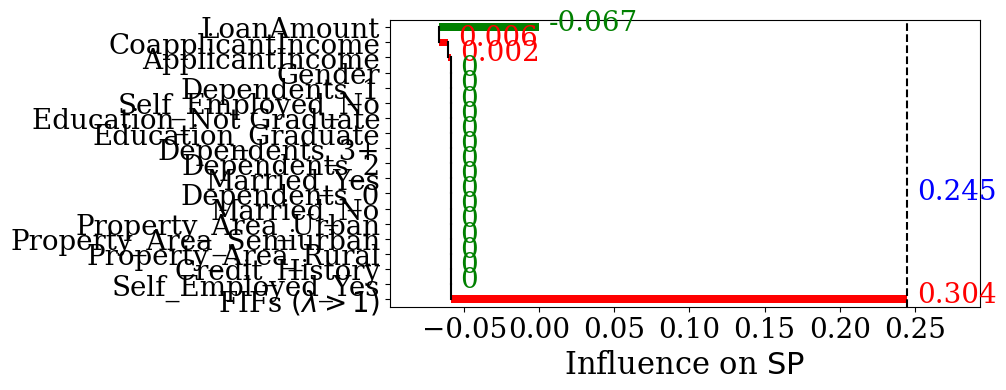

Exact statistical parity 0.24537815126050416


<Figure size 1000x400 with 0 Axes>

In [20]:
result = fairXplainer.get_weights()

fontsize = 22
labelsize = 20

plt = fif_plot(result, 
                draw_waterfall=True, 
                labelsize=labelsize, 
                figure_size=(10,4), 
                text_y_pad=0.2, 
                xlim=None, 
                result_y_location=0.6,
                x_label="Influence on " + r"$ \mathsf{SP} $"
            )
plt.show()
plt.clf()
print("Exact statistical parity", fairXplainer.statistical_parity_sample())

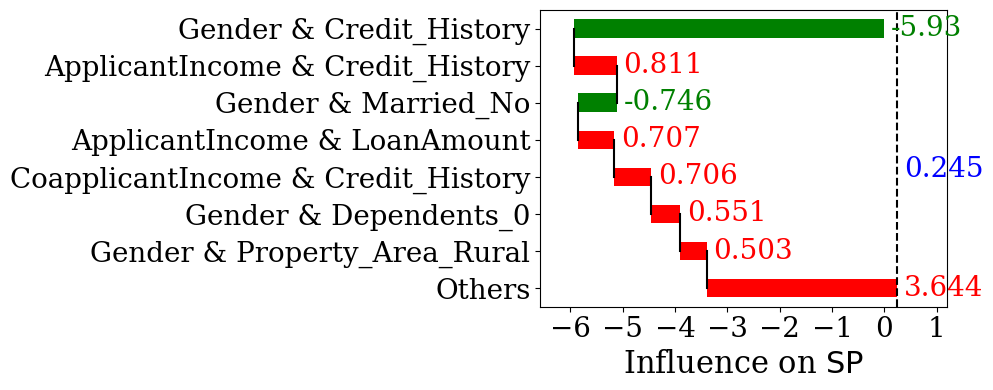

Exact statistical parity 0.24537815126050416


<Figure size 1000x400 with 0 Axes>

In [21]:
%matplotlib inline
k = 7
result = fairXplainer.get_top_k_weights(k=k)
plt = fif_plot(result, 
               draw_waterfall=True, 
               labelsize=labelsize, 
               figure_size=(10,4), 
               text_y_pad=0.2, 
               xlim=None, 
               result_x_pad=0.02,
               x_label="Influence on " + r"$ \mathsf{SP} $"
        )
plt.tight_layout()
plt.show()
plt.clf()

print("Exact statistical parity", fairXplainer.statistical_parity_sample())

### Applying the Disparate Impact Remover to the dataset

In [22]:
import aif360
from aif360.algorithms.preprocessing import DisparateImpactRemover
# binaryLabelDataset = aif360.datasets.BinaryLabelDataset(
#     df=yourDataFrameHere,
#     label_names=['yourOutcomeLabelHere'],
#     protected_attribute_names=['yourProtectedClassHere'])
# Must be a binaryLabelDataset
binaryLabelDataset = aif360.datasets.BinaryLabelDataset(
    favorable_label=1,
    unfavorable_label=0,
    df=encoded_df,
    label_names=['Loan_Status'],
    protected_attribute_names=['Gender'])
di = DisparateImpactRemover(repair_level = 1.0)
dataset_transf_train = di.fit_transform(binaryLabelDataset)
transformed = dataset_transf_train.convert_to_dataframe()[0]
transformed

,Gender,ApplicantIncome,CoapplicantIncome,LoanAmount,Credit_History,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban,Married_No,Married_Yes,Dependents_0,Dependents_1,Dependents_2,Dependents_3+,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Loan_Status
1,1.0,3958.0,1483.0,108.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,1.0,2600.0,0.0,59.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
3,1.0,2241.0,2333.0,102.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
4,1.0,4723.0,0.0,115.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
5,1.0,4402.0,3683.0,189.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
975,1.0,2101.0,2183.0,79.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
976,1.0,3719.0,1762.0,94.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
977,1.0,3762.0,717.0,95.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
979,1.0,4230.0,2333.0,130.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [23]:
encoded_df

,Gender,ApplicantIncome,CoapplicantIncome,LoanAmount,Credit_History,Loan_Status,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban,Married_No,Married_Yes,Dependents_0,Dependents_1,Dependents_2,Dependents_3+,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes
1,1,4583,1508.0,128.0,1.0,0,1,0,0,0,1,0,1,0,0,1,0,1,0
2,1,3000,0.0,66.0,1.0,1,0,0,1,0,1,1,0,0,0,1,0,0,1
3,1,2583,2358.0,120.0,1.0,1,0,0,1,0,1,1,0,0,0,0,1,1,0
4,1,6000,0.0,141.0,1.0,1,0,0,1,1,0,1,0,0,0,1,0,1,0
5,1,5417,4196.0,267.0,1.0,1,0,0,1,0,1,0,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
975,1,2269,2167.0,99.0,1.0,1,0,1,0,0,1,0,1,0,0,1,0,1,0
976,1,4009,1777.0,113.0,1.0,1,0,0,1,0,1,0,0,0,1,0,1,0,1
977,1,4158,709.0,115.0,1.0,1,0,0,1,0,1,1,0,0,0,1,0,1,0
979,1,5000,2393.0,158.0,1.0,0,1,0,0,0,1,1,0,0,0,1,0,1,0


### Train a model using the dataset that underwent the pre-processing

In [24]:
x_trans = transformed.drop(['Loan_Status'], axis = 1)
y = transformed['Loan_Status']
# Liblinear is a solver that is effective for relatively smaller datasets.
model_trans = LogisticRegression(solver='liblinear', class_weight='balanced')
scaler = StandardScaler()
data_minmax = scaler.fit_transform(x_trans)
# Splitting into test and training
# We will follow an 80-20 split pattern for our training and test data
x_trans_train,x_trans_test,y_trans_train,y_trans_test = train_test_split(x_trans, y, test_size=0.2, random_state = 0)

In [ ]:
model_trans.fit(x_trans_train, y_trans_train)

LogisticRegression(class_weight='balanced', solver='liblinear')

### Evaluating performance

In [ ]:
y_trans_pred = pd.Series(model.predict(x_trans_test))
print("Accuracy:", metrics.accuracy_score(y_test, y_trans_pred))
print("Precision:", metrics.precision_score(y_test, y_trans_pred))
print("Recall:", metrics.recall_score(y_test, y_trans_pred))

Accuracy: 0.8246753246753247
Precision: 0.8773584905660378
Recall: 0.8691588785046729


### Calculating disparate impact on predicted values by model trained on transformed dataset

In [ ]:
gender_1_prediction_prob, gender_0_prediction_prob = y_trans_pred[(x_trans_test['Gender'] == 1).values].mean(), y_trans_pred[(x_trans_test['Gender'] == 0).values].mean()

In [ ]:
# Calculating disparate impact
disparate_impact = min(gender_1_prediction_prob, gender_0_prediction_prob) / max(gender_1_prediction_prob, gender_0_prediction_prob)
print("Disparate Impact, Sex vs. Predicted Loan Status: " + str(disparate_impact))

Disparate Impact, Sex vs. Predicted Loan Status: 0.6954545454545453


In [ ]:
from justicia.metrics import Metric
metric = Metric(model=model_trans, 
                data=x_trans_test, 
                sensitive_attributes=['Gender'], 
                verbose=True, 
                encoding="best-correlated",
                discretization_bins=15,
                dag_threshold=0.7)
metric.compute()
print("Sensitive attributes", metric.given_sensitive_attributes)
print("Disparate Impact:", metric.disparate_impact_ratio)
print("Statistical Parity:", metric.statistical_parity_difference)
print("Time taken", metric.time_taken, "seconds")

Learn-dependency encoding is solved based on Learn-efficient-dependency encoding
Expression:  -1 0 1 2 4 5 6 7 8 9 10 11 12 13 0 0 0 0 0 0 0 0 0 0 0 0 0 -1 -4 -7 -10 -12 -15 -18 -20 -23 -26 -28 -31 -34 0 1 2 3 4 51 -12 3 -4 -9 -3 -7 -8 1 0 -3 -9 -6 -7 ?= 13
Translation accuracy 0.987012987012987
Total number of variables in the formula: 59

---------------------------
Starting DAG learning
Maximum iteration 1  edges: 1 nodes 2
[('51', '50')]
Maximum iteration 5  edges: 5 nodes 10
[('4', '3'), ('49', '48'), ('51', '50'), ('56', '57'), ('59', '58')]
Maximum iteration 10  edges: 10 nodes 17
[('4', '3'), ('43', '45'), ('47', '48'), ('49', '48'), ('51', '50'), ('53', '52'), ('54', '52'), ('55', '52'), ('56', '57'), ('59', '58')]
Maximum iteration 50  edges: 50 nodes 44
[('2', '3'), ('2', '29'), ('3', '29'), ('4', '3'), ('5', '3'), ('6', '32'), ('8', '3'), ('10', '35'), ('11', '32'), ('12', '32'), ('14', '3'), ('14', '32'), ('15', '51'), ('15', '29'), ('16', '15'), ('16', '17'), ('17', '15')